<a href="https://colab.research.google.com/github/arshiyasaiyad/Calculator/blob/main/anomalydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

!

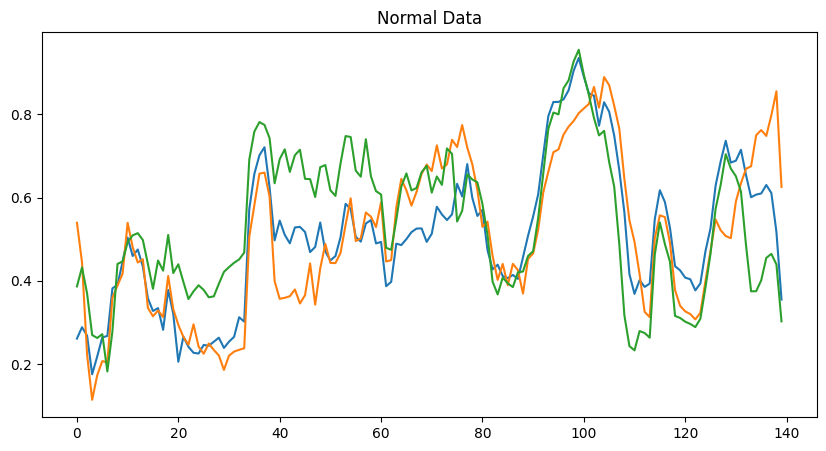

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()


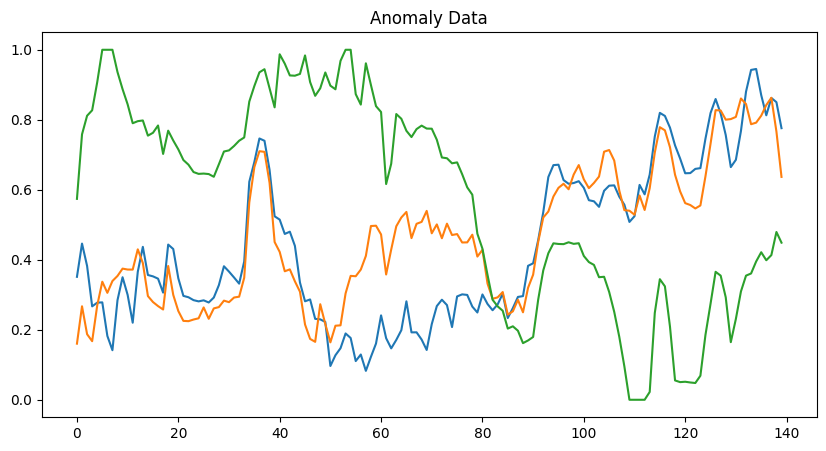

In [ ]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()



In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(140, activation="sigmoid"))

In [ ]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()


Epoch 1/50
4/4 [==============================] - 2s 85ms/step - loss: 0.1637 - val_loss: 0.1515
Epoch 2/50
4/4 [==============================] - 0s 19ms/step - loss: 0.1596 - val_loss: 0.1480
Epoch 3/50
4/4 [==============================] - 0s 36ms/step - loss: 0.1518 - val_loss: 0.1439
Epoch 4/50
4/4 [==============================] - 0s 39ms/step - loss: 0.1415 - val_loss: 0.1394
Epoch 5/50
4/4 [==============================] - 0s 45ms/step - loss: 0.1306 - val_loss: 0.1335
Epoch 6/50
4/4 [==============================] - 0s 42ms/step - loss: 0.1191 - val_loss: 0.1280
Epoch 7/50
4/4 [==============================] - 0s 50ms/step - loss: 0.1082 - val_loss: 0.1217
Epoch 8/50
4/4 [==============================] - 0s 32ms/step - loss: 0.0989 - val_loss: 0.1178
Epoch 9/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0913 - val_loss: 0.1134
Epoch 10/50
4/4 [==============================] - 0s 26ms/step - loss: 0.0851 - val_loss: 0.1098
Epoch 11/50
4/4 [============

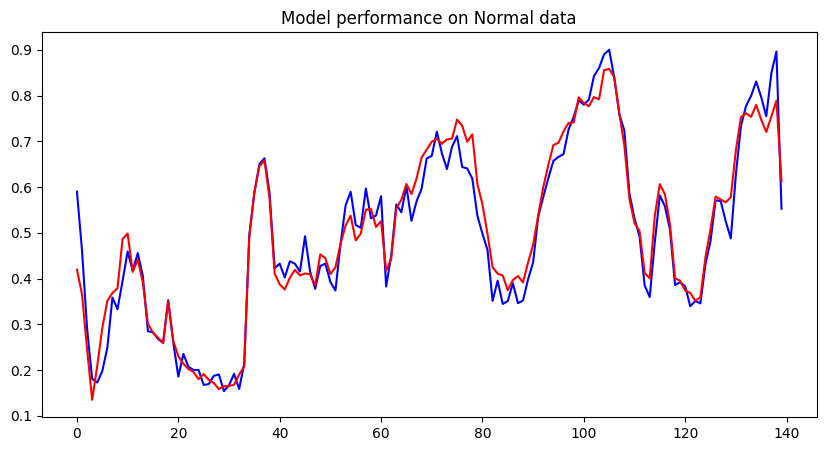

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

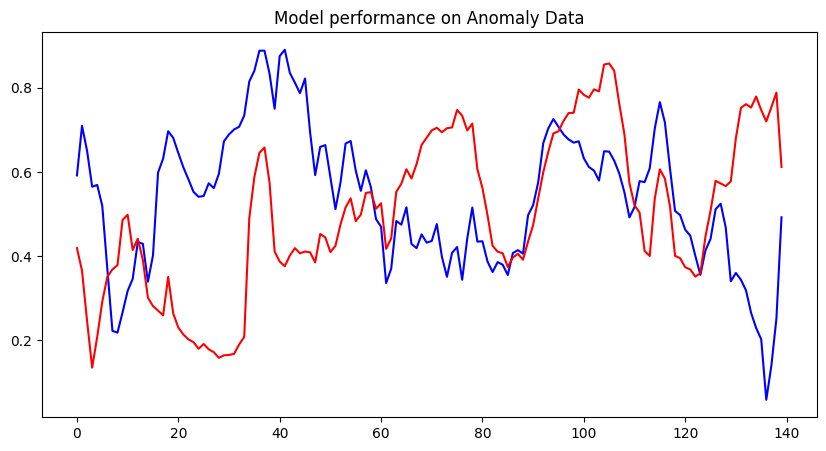

In [ ]:
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

3/3 [==============================] - 0s 6ms/step


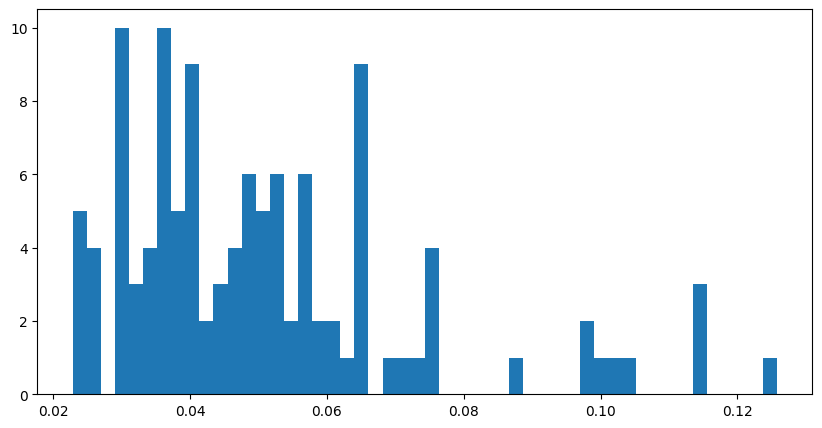

In [ ]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)

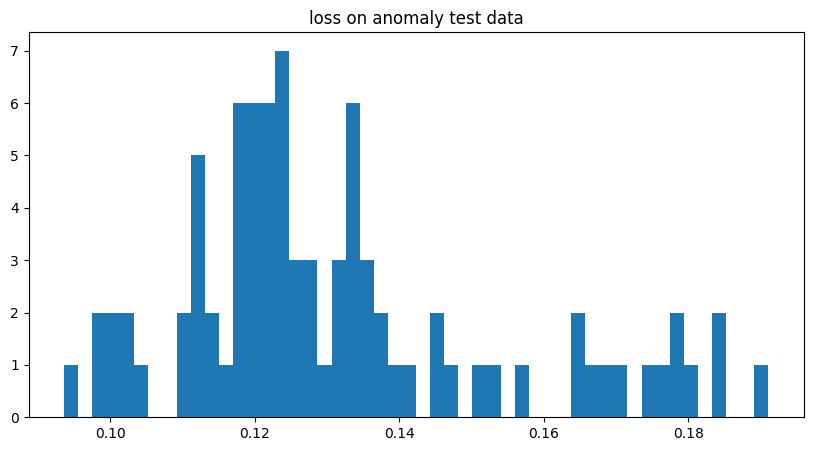

In [ ]:
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

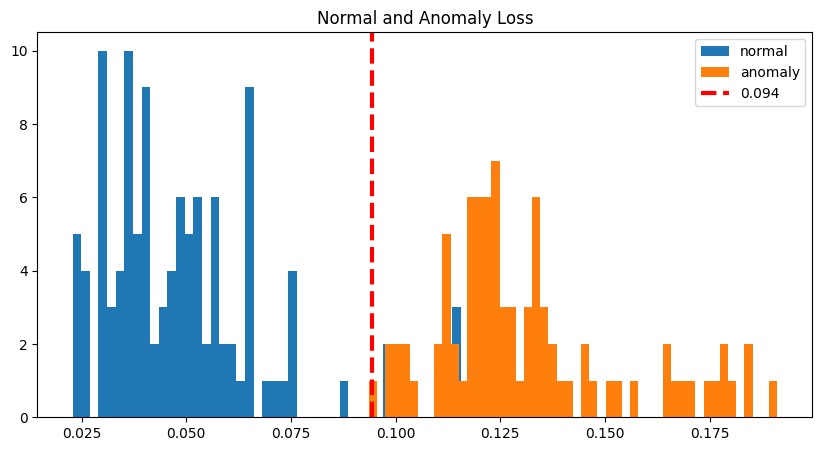

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [ ]:
preds = tf.math.less(train_loss, threshold)
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=106>

In [ ]:
preds_a = tf.math.greater(train_loss_a, threshold)
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=84>